In [ ]:
%%bash
git clone https://github.com/ZhuoqunWang0120/cs671kaggle.git

Cloning into 'cs671kaggle'...


In [1]:
import lightgbm
import os
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt


In [2]:
os.chdir('./cs671kaggle')

In [3]:
train_data = pd.read_csv('data/train.csv')
train_data = train_data.dropna()
# drop id
train_data = train_data.drop(columns = 'id')
# transform age to age groups
train_data.Age = list(map(lambda s: s[0], train_data.Age.astype('str')))
# transform dtype of temperature
train_data.Temperature = train_data.Temperature.astype('float')
# one-hot encoding
train_data = pd.get_dummies(train_data,dummy_na=False)

In [4]:
Xtrain, ytrain = train_data.drop(columns = 'Decision'), train_data.Decision

In [5]:
params ={'num_leaves': np.arange(5, 50, 1), 
             'min_data_in_leaf': np.arange(10, 200, 10)
}

In [6]:
clf = lightgbm.LGBMClassifier(max_depth = -1, random_state=0, silent=True, metric='None', n_estimators = 500)


In [7]:
lgb_cv = RandomizedSearchCV(
    estimator = clf, 
    n_iter = 100,
    param_distributions = params,
    scoring='accuracy',
    cv = 5, # 5fold
    random_state = 0,
    verbose = True)

In [8]:
lgb_cv.fit(Xtrain, ytrain)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(metric='None', n_estimators=500,
                                            random_state=0),
                   n_iter=100,
                   param_distributions={'min_data_in_leaf': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190]),
                                        'num_leaves': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
                   random_state=0, scoring='accuracy', verbose=True)

In [9]:
print(lgb_cv.best_params_, lgb_cv.best_score_)

{'num_leaves': 36, 'min_data_in_leaf': 70} 0.769532481633797


In [10]:
%%time
lgb_best = lgb_cv.best_estimator_.fit(Xtrain, ytrain)

CPU times: user 2.2 s, sys: 63.9 ms, total: 2.27 s
Wall time: 1.19 s


In [11]:
np.mean(cross_val_score(lgb_cv.best_estimator_, Xtrain, ytrain, cv = 5, scoring = 'accuracy'))

0.769532481633797

In [13]:
test_data = pd.read_csv('data/test.csv')
test_data.Age = list(map(lambda s: s[0], test_data.Age.astype('str')))
test_data.Temperature = test_data.Temperature.astype('float')
Xtest = test_data.drop(columns = 'id')
Xtest = pd.get_dummies(Xtest,dummy_na = False)

In [17]:
sub9 = pd.DataFrame({'id': test_data.id, 'Decision': lgb_best.predict(Xtest)})
sub9.to_csv('sub9.csv',index=False, header='sub9')

In [18]:
import pickle
with open('lightgbm_sub9.pkl','wb') as f1:
    pickle.dump(lgb_best,f1)
with open('lightgbm_cv_sub9.pkl','wb') as f2:
    pickle.dump(lgb_cv,f2)

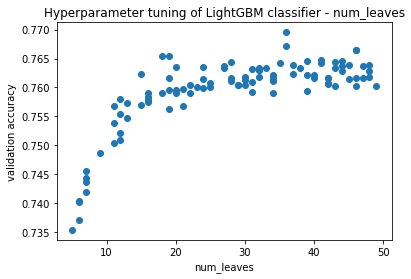

In [37]:
plt.scatter(np.array(lgb_cv.cv_results_['param_num_leaves'], dtype = float), lgb_cv.cv_results_['mean_test_score'])
plt.title('Hyperparameter tuning of LightGBM classifier - num_leaves')
plt.xlabel('num_leaves')
plt.ylabel('validation accuracy')
pass

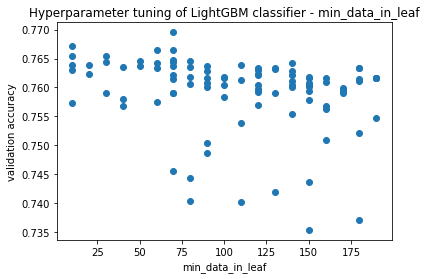

In [38]:
plt.scatter(np.array(lgb_cv.cv_results_['param_min_data_in_leaf'], dtype = float), lgb_cv.cv_results_['mean_test_score'])
plt.title('Hyperparameter tuning of LightGBM classifier - min_data_in_leaf')
plt.xlabel('min_data_in_leaf')
plt.ylabel('validation accuracy')
pass